0 : error=5.8875
10 : error=2.2817
20 : error=0.9308
30 : error=0.4867
40 : error=0.2977
50 : error=0.1907
60 : error=0.1227
70 : error=0.0788
80 : error=0.0508
90 : error=0.0332
100 : error=0.0224
110 : error=0.0157
120 : error=0.0116
130 : error=0.0089
140 : error=0.0072
150 : error=0.0059


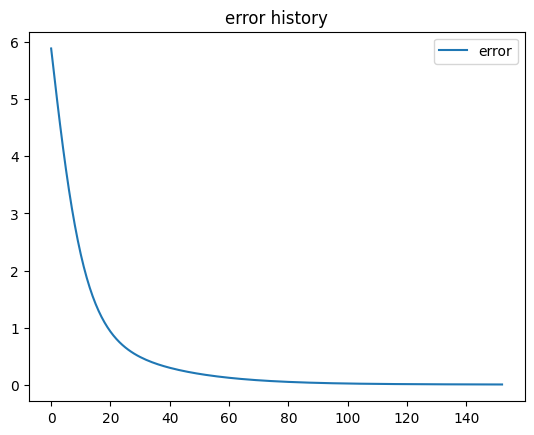


R :
[[ 4. nan nan  2. nan]
 [nan  5. nan  3.  1.]
 [nan nan  3.  4.  4.]
 [ 5.  2.  1.  2. nan]]

Estimated R :
[[4.02 2.63 1.37 1.93 1.9 ]
 [3.87 4.99 2.23 2.91 1.09]
 [8.39 5.61 2.91 4.09 3.93]
 [4.96 1.99 1.14 1.94 2.64]]

F :
[[ 0.53  0.57  1.14]
 [ 2.    0.28  0.78]
 [ 1.17  1.19  2.35]
 [-0.05  1.14  1.32]]

B :
[[ 0.79  1.97  0.79  1.01 -0.08]
 [ 1.71  0.51  0.15  0.75  0.79]
 [ 2.32  1.14  0.77  0.86  1.32]]


In [1]:
# 행렬 분해 : R = F * B
# NaN이 포함된 R이 주어졌을 때 행렬 F, B를 추정한다. (by Stochastic Gradient Descent)
import numpy as np
import numba as nb
import matplotlib.pyplot as plt

# User-item matrix
N = np.NaN
R = np.array([[4, N, N, 2, N],
              [N, 5, N, 3, 1],
              [N, N, 3, 4, 4],
              [5, 2, 1, 2, N]])

N_ROW = R.shape[0]
N_COL = R.shape[1]

@nb.jit
# SGD로 행렬 F, B를 업데이트한다.
def update_matrix(R, F, B, a, r):
    for i in range(N_ROW):
        for j in range(N_COL):
            if np.isnan(R[i, j]) != True:  # nan이 아니면
                # error 항을 계산한다.
                eij = R[i, j] - np.dot(F[i, :], B[j, :])
                
                # update F, B
                F[i, :] += a * (eij * B[j, :] - r * F[i, :])
                B[j, :] += a * (eij * F[i, :] - r * B[j, :])

@nb.jit
# NaN이 포함된 행렬의 mean_squared_error를 계산한다. 행렬 x에는 NaN이 포함돼 있다. y에는 없다.
def mse_skip_nan(x, y):
    mse = 0.0
    cnt = 0
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            if np.isnan(x[i, j]) != True:  # nan이 아니면
                mse += (x[i, j] - y[i, j]) ** 2
                cnt += 1
    return mse / cnt

# SGD로 행렬을 F, B로 분해한다.
def factorize_matrix(matR, k, max_iter=1000, alpha=0.01, gamma=0.01, err_limit=1e-4):
    # F, B를 random 초기화한다.
    F = np.random.rand(N_ROW, k)  # factor matrix
    B = np.random.rand(N_COL, k)  # beta matrix.

    old_err = 9999   # error 초깃값
    err_hist = []    # error history
    for step in range(max_iter):
        # F, B를 업데이트한다.
        update_matrix(matR, F, B, alpha, gamma)

        # error를 계산하고 저장해 둔다.
        err = mse_skip_nan(matR, np.dot(F, B.T))
        err_hist.append(err)

        # early stopping
        if np.abs(old_err - err) < err_limit:
            break
        
        old_err = err

        if step % 10 == 0:
            print('{} : error={:.4f}'.format(step, err))

    if step >= max_iter - 1:
        print('max_iter={}번 동안 stop하지 못했습니다.'.format(max_iter))
        print('max_iter를 늘리거나 err_limit을 늘려야 합니다.')

    return F, B.T, err_hist

K = 3               # number of factors
F, B, err = factorize_matrix(R, K)
ER = np.dot(F, B)   # estimated R

# error history를 관찰한다.
plt.plot(err, label='error')
plt.legend()
plt.title('error history')
plt.show()

print('\nR :')
print(np.round(R, 2))
print('\nEstimated R :')
print(np.round(ER, 2))   
print('\nF :')
print(np.round(F, 2))
print('\nB :')
print(np.round(B, 2))